# Tutorial 6: Wiener filter, ML vs MAP, Anscombe transform

In the last tutorial we have defined what an inverse problem means and prpoposed one way to solve them -- inverse filtering. Today, we will look at wiener filter, the notion of ML and MAP estimators and compare them on a task of non-blind deconvolution. We will then induce some very simple priors on the image. Finally, on a different note, we will look at how to deal with non-Gaussian noise (such as Poisson noise).


Agenda:
 - Problem with inverse filtering
 - Wiener filter
 - ML estimation
 - MAP estimation
 - Bayesian estimation with simple priors
 - Anscombe transform

In [128]:
% matplotlib inline
import numpy as np
import cv2
from PIL import Image
from scipy.signal import convolve2d as conv2d
from matplotlib import pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift

Let $I(x,y)$ be the clean image and $\hat{I}(x,y)$ be the blurred version, that is obtained by the blur PSF $H(x, y)$. For now, let us ignore the noise.

$$
\hat{I}(x,y) = H(x, y) \ast I(x, y) + \mathcal{\eta}
$$

where $\mathcal{\eta} \sim \mathcal{N}(0,\sigma^2)$ 

### Problem with inverse filtering

Like we saw in the last class, if we perform the inverse filtering by doing 

$$
{I}(u, v) = \frac{\hat{I}(u, v)}{H(u, v)}
$$

In the noisy case if we divide $\hat{I}(x, y)$ with the Fourier transform of noise, it will lead to just amplifying the noise. 


Let's see what this means in code.


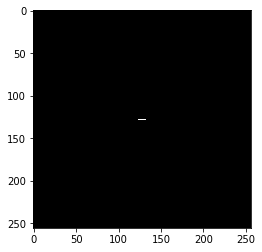

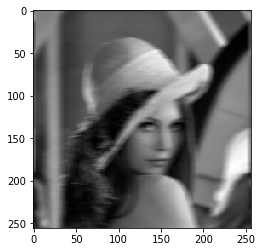

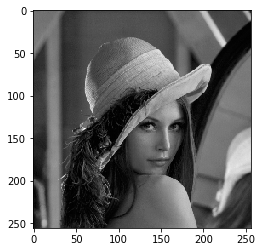

In [129]:
# We'll look at truncated inverse filter. Let's assume that the blur is because of motion.

image = cv2.imread('lena.jpg',0)
image = cv2.resize(image, (256, 256))

## Motion blur
def motion_process(leng, size):
    sx, sy = size
    PSF = np.zeros((sy, sx))
    PSF[int(sy / 2):int(sy /2 + 1), int(sx / 2 - leng / 2):int(sx / 2 + leng / 2)] = 1
    return PSF / PSF.sum()

def inverse_filter(inputs, PSF):
    input_fft = fft2(inputs)
    PSF_fft = fft2(PSF)
    input_fft_scaled = input_fft/input_fft.max()
    PSF_fft_scaled = PSF_fft/PSF_fft.max()
    PSF_fft_scaled[PSF_fft_scaled == 0] = 0.000005
    recovered_fft_scaled = input_fft_scaled/PSF_fft_scaled
    recovered_fft = recovered_fft_scaled*input_fft.max()
    result = ifft2(recovered_fft)
    result = np.real(fftshift(result))
    return result


def make_blurred(inputs, PSF):
    input_fft = fft2(inputs)
    PSF_fft = fft2(PSF)
    blurred = ifft2(input_fft * PSF_fft)
    blurred = np.abs(fftshift(blurred))
    return blurred

psf_motion_blur = motion_process(leng=10, size=image.shape)

plt.figure()
plt.imshow(psf_motion_blur, cmap='gray')
plt.show()

motion_blurred_image = make_blurred(image, psf_motion_blur)

plt.figure()
plt.imshow(motion_blurred_image, cmap='gray')
plt.show()

deblurred_motion_image = inverse_filter(motion_blurred_image, psf_motion_blur)

plt.figure()
plt.imshow(deblurred_motion_image, cmap='gray')
plt.show()

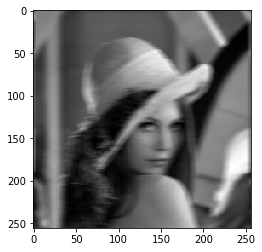

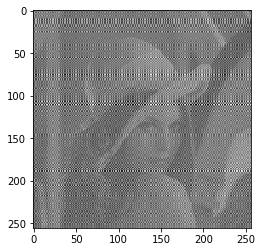

In [130]:
noise_var = 0.01
noisy_motion_blurred_image = make_blurred(image, psf_motion_blur) + noise_var*np.random.randn(image.shape[0], image.shape[1])

plt.figure()
plt.imshow(noisy_motion_blurred_image, cmap='gray')
plt.show()

deblurred_noisy_motion_image = inverse_filter(noisy_motion_blurred_image, psf_motion_blur)

plt.figure()
plt.imshow(deblurred_noisy_motion_image, cmap='gray')
plt.show()

## The problem of noise amplification:

$$ 
\hat{I} (u, v) = H (u, v) I (u, v) + N(u, v)
$$

Inverse filtering yields

$$
\tilde{I} (u, v) = \frac{\hat{I} (u, v)}{H(u,v)} = I(u, v) + \frac{N(u, v)}{H(u, v)}
$$

<img src='noise-amplification.png'>



As we can see, the inverse filtering totally fails with the injection of simple Gaussian noise into our forward model because the noise amplifies when divided by $H(u, v)$. Wiener filter fixes this.

## The Wiener Filter

If our forward model is defined as,

$$
\hat{I}(x,y) = H(x, y) \ast I(x, y) + \mathcal{\eta}(x,y)
$$

then the Wiener filter is defined as

$$
\tilde{I} (u, v) = W(u, v) \hat{I}(u, v)
$$

in which  

$$
W(u, v) = \frac{H^{\ast}(u, v)}{|H(u, v)|^2 + K(u, v)}
$$

where

$$
K(u, v) = \frac{S_\eta (u, v)}{S_I(u, v)}
$$

and 

$$
S_I(u, v) = | I(u, v)|^2, \text{i.e., the PSD of } f(x, y)
$$

$$ 
S_\eta (u, v) = | \eta(u, v)|^2, \text{i.e., the PSD of } \eta(x, y)
$$

### Frequency behavior

if $K = 0$, i.e. the noise less case, then $W(u, v) = 1/H(u, v)$ -- inverse filter

if $K >> |H(u, v)|$ for large $u, v$ the high frequencies are attenuated.

In practice: 

- $| \hat{I}(u, v) | \text{and  }  |N (u,v)|$ are known approximately

- K is set to a constant scalar which is a hyper-parameter

It can be observed in the following figure:

<img src='noise-suppresion-wiener.png'>



Now let's see how to implement the Wiener filter

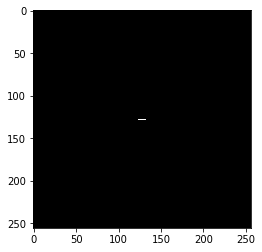

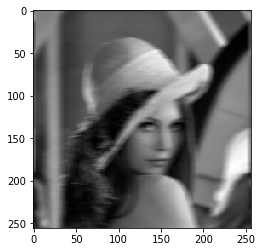

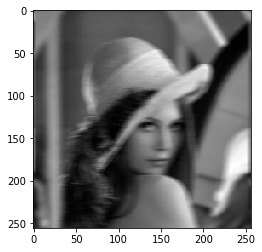

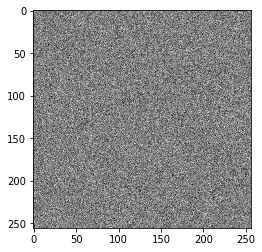

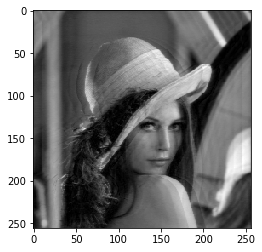

In [132]:
## Wiener filter

def weiner_filter(img, kernel, K):
    y = np.copy(img)
    Y = fft2(y)
    H = fft2(kernel)
    G = np.conj(H)/(np.abs(H) ** 2 + K)
    Y_hat = G * Y
    y_hat = np.abs(fftshift(ifft2(Y_hat)))
    return y_hat

# psf of blur
psf_motion_blur = motion_process(leng=10, size=image.shape)

plt.figure()
plt.imshow(psf_motion_blur, cmap='gray')
plt.show()

# blurring the image
motion_blurred_image = make_blurred(image, psf_motion_blur)

plt.figure()
plt.imshow(motion_blurred_image, cmap='gray')
plt.show()

# add noise
noise_var = 0.01
noise_img = noise_var*np.random.randn(image.shape[0], image.shape[1])

noisy_motion_blurred_image = make_blurred(image, psf_motion_blur) + noise_img
plt.figure()
plt.imshow(noisy_motion_blurred_image, cmap='gray')
plt.show()

plt.figure()
plt.imshow(noisy_motion_blurred_image-motion_blurred_image, cmap='gray')
plt.show()

wiener_filtered_image = weiner_filter(noisy_motion_blurred_image, psf_motion_blur, 0.01)

plt.figure()
plt.imshow(wiener_filtered_image, cmap='gray')
plt.show()

## ML vs MAP estimation


Say the degradation is modeled as follows

$$
\hat{I} = H I + \mathcal{N}
$$


### ML estimator

In ML, we are trying to find the right model within the parametrized set of models that fits our data well.


$$
\tilde{I} = \arg \max_{{I}}  P (\hat{I} | I)
$$




### MAP estimator

In MAP, we are trying to find the model which maximizes the posterior distribution (i.e. the one that maximizes the occurence of the observed data given the model)

It can be formalized as follows:

$$
\tilde{I} = \arg \max_{{I}} P({I} | \hat{I}) = \arg \max_{{I}} \frac{P (\hat{I} | {I}) P (I)}{P(\hat{I})} = \arg \max_{{I}} P (\hat{I} | I) P ({I})
$$


### ML deconvolution

From the degradation model, we have $ \mathcal{N} = \hat{I} - H I $.

If the noise in the observed image follows Gaussian distribution. Then it means the probability of seeing the degraded image given a clean image follows the following Gaussian distribution where the random variable is $\hat{I} - H I$

$$
P (\hat{I} | I) = P (\mathcal{N}) \propto \frac{1}{ (2\pi)^{N/2} |C_{ww}|^{1/2} } \text{exp}\left[ -\frac{1}{2} (\hat{I} - H I)^T C_{ww}^{-1} (\hat{I} - H I) \right]
$$

This is the multivariate Gaussian distribution for $N$ samples. If the noise is white: $ C_{ww} = \beta^{-1} I $. This simplifies further to

$$
P (\hat{I} | I) \propto \beta^{N/2} \text{exp} \left[ - \frac{1}{2} \beta || \hat{I} - H I ||^2   \right]
$$

Therefore if we would like to minimize the earlier proposed ML estimator, we are supposed to minimize the above expression. For simplicity, to avoid the exponents, we can rather minimize the "log" of the proposed expression (this won't change anything since log is an monotonically increasing function). Therefore applying log we get:

$$
\tilde{I} = \arg \min_{I}  \frac{1}{2} \beta || \hat{I} - H I ||^2 
$$

If we assume that H is convolution then by Parseval's theorem this is equivalent to 

$$
\tilde{I} = \arg \min_{I_F}  \frac{1}{2} \beta || \hat{I}_F - H_F I_F ||^2 
$$

As we saw below, this is just the Weiner filter which is minimized by $\frac{\hat{I}_F}{H_F}$. We know it's not so good. 


### MAP restoration

Let's see this with an example of a simple prior.




### Smoothness priors

Let us try to enforce a smoothness prior on our image. How do we do so?

We can simply induce it by saying that the $P I$ image follows a Gaussian distribution with zero mean and variance $\sigma_p^2$. If $PI$ is a random variable, then the distribution can be defined as follows

$$
\text{P} ({I}) = \text{exp} \{ - \frac{|| P I ||^2}{\sigma_p^2} \}
$$


Inducing this into the MAP estimator

$$
\arg \max_{{I}} P (\hat{I} | I) P ({I})
$$

$$
\tilde{I} = \arg \min_{I}  \frac{1}{2} \beta || \hat{I} - H I ||^2 + \lambda \sigma_p^2 || P I ||^2
$$

Again through Parseval's identity

$$
 || \hat{I}_F - H_F I_F ||^2 + \lambda \frac{\beta^{-1}}{\sigma^2} || P_F I_F ||^2
$$

$$
\hat{I}_F^{\ast}\hat{I}_F  - \hat{I}_F^{\ast} H_F I_F - \hat{I}_F H_F^{\ast} I_F + \left( H_F^{\ast} H_F +  \frac{\beta^{-1}}{\sigma^2} P_F^{\ast} P_F \right)
$$

This is a quadratic function in $I_F$ which has a closed form minimum. 

$$
I_F = \frac{H_F^{\ast}} {H_F^{\ast} H_F + \frac{\beta^{-1}}{\sigma^2}  P_F^{\ast} P_F } \hat{I}_F
$$



This problem can also be solved in the spatial domain but would involve inverting huge matrices.


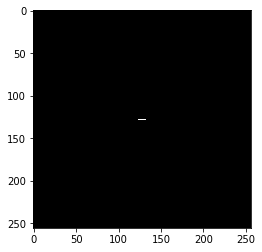

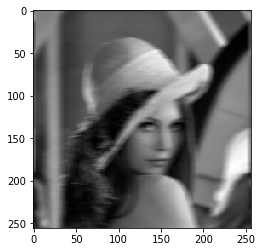

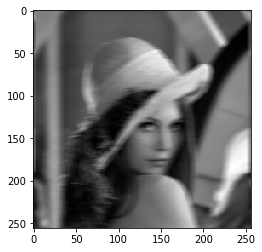

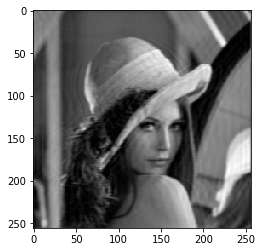

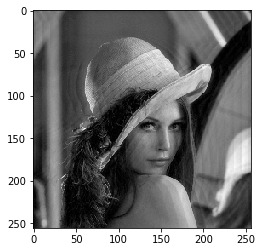

In [134]:
## Constrained Least Squares
def constrain_ls_filter(img, kernel, r):
    y = np.copy(img)
    Y = fft2(y)
    H = fft2(kernel)
    p = [[0, -1, 0], [-1, 4, -1], [0, -1, 0]]
    p = np.array(p)
    P = np.fft.fft2(p, s=(img.shape[0], img.shape[1]))
    G = np.conj(H)/(np.abs(H) ** 2 + r*np.abs(P) ** 2)
    X_hat = G * Y
    x_hat = np.abs(ifft2(X_hat))
    return fftshift(x_hat)

def constrain_low_pass_filter(img, kernel, r):
    y = np.copy(img)
    Y = fft2(y)
    H = fft2(kernel)
    p = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    p = np.array(p)/9.0
    P = np.fft.fft2(p, s=(img.shape[0], img.shape[1]))
    G = np.conj(H)/(np.abs(H) ** 2 + r*np.abs(P) ** 2)
    X_hat = G * Y
    x_hat = np.abs(ifft2(X_hat))
    return fftshift(x_hat)

# psf of blur
psf_motion_blur = motion_process(leng=10, size=image.shape)

plt.figure()
plt.imshow(psf_motion_blur, cmap='gray')
plt.show()

# blurring the image
motion_blurred_image = make_blurred(image, psf_motion_blur)

plt.figure()
plt.imshow(motion_blurred_image, cmap='gray')
plt.show()

# add noise
noise_var = 0.01
noise_img = noise_var*np.random.randn(image.shape[0], image.shape[1])

noisy_motion_blurred_image = make_blurred(image, psf_motion_blur) + noise_img
plt.figure()
plt.imshow(noisy_motion_blurred_image, cmap='gray')
plt.show()

constrained_ls_filtered_image = constrain_ls_filter(noisy_motion_blurred_image, psf_motion_blur, 0.01)

plt.figure()
plt.imshow(constrained_ls_filtered_image, cmap='gray')
plt.show()


constrained_lp_filtered_image = constrain_low_pass_filter(noisy_motion_blurred_image, psf_motion_blur, 0.01)

plt.figure()
plt.imshow(constrained_lp_filtered_image, cmap='gray')
plt.show()


### Anscombe transform

How to deal with Poisson noise? Do a variance stablizing transform and convert it to a Gaussian one with unitary variance, do denoising there and then do an inverse transform to get the denoised image.

<img src='anscombe-transform.png'>



252
1.0
20.0


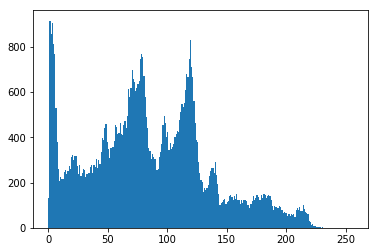

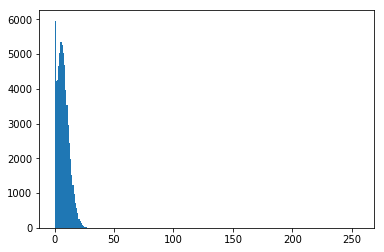

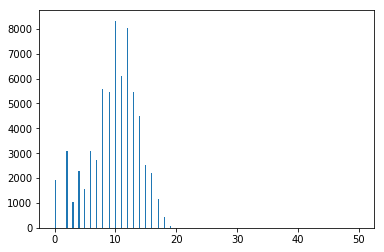

35.0


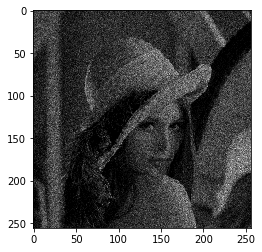

30


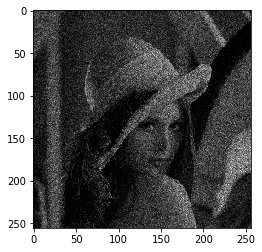

35.0


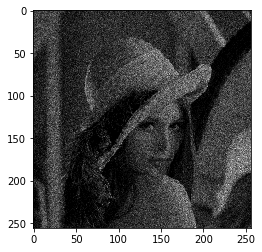

30


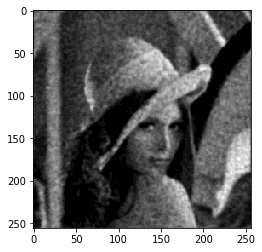

In [137]:
import math

def AnscombeTrans(imdata):
    imdata = np.float32(imdata)
    z = 2*np.sqrt(imdata+3/8)

    return np.uint16(z)

def InAnscombeTrans(imdata, opt = 'exact'):
    imdata = np.float32(imdata)
    if opt == 'algebra':
        z = imdata*imdata/4 - 3/8
        
    if opt == 'asymptotic':
        z = imdata*imdata/4 - 1/8

    if opt == 'exact':
        z = imdata*imdata/4 + math.sqrt(3/2)/imdata/4 - 11/8/(imdata*imdata) + \
            5/8*math.sqrt(3/2)/(imdata*imdata*imdata) - 1/8
        z = np.maximum(z, np.zeros(imdata.shape, dtype=np.float32))

    return np.uint16(z)   


def add_poiss_noise_image(img):
    sy,sx = img.shape
    lambda_flat = np.reshape(img,[-1,1]).astype(np.float32)
    noisy_flat = np.random.poisson(lam=lambda_flat)
    noisy = np.reshape(noisy_flat,[sy,sx])
    return(noisy.astype(np.float32))

noise_peak = 20
max_val = np.amax(np.amax(image))
print(max_val)
scaled_img = image.astype(np.float32) * (1.0 / float(max_val))
print(np.max(scaled_img))
img_peak = (scaled_img)*float(noise_peak)
print(np.max(img_peak))

plt.hist(image.ravel(),256,[0,256]); plt.show()

poiss_noisy = add_poiss_noise_image(img_peak)  # noisy image

plt.hist(poiss_noisy.ravel(),256,[0,256]); plt.show()

trans_anscombe = AnscombeTrans(poiss_noisy)

plt.hist(Anscombe_transformed_dist.ravel(),256,[0,50]); plt.show()

psf_blur = np.zeros([256,256])
psf_blur[128,128] = 1

denoised_transformed_weiner = weiner_filter(trans_anscombe, psf_blur, 0)

inv_transcombe_img = InAnscombeTrans(denoised_transformed_weiner, opt='algebra')


print(poiss_noisy.max())
plt.figure()
plt.imshow(poiss_noisy, cmap='gray')
plt.show()


print(inv_transcombe_img.max())
plt.figure()
plt.imshow(inv_transcombe_img, cmap='gray')
plt.show()



denoised_transformed_constrained_ls = constrain_ls_filter(trans_anscombe, psf_blur, 1)

inv_transcombe_const_ls = InAnscombeTrans(denoised_transformed_constrained_ls, opt='algebra')


print(poiss_noisy.max())
plt.figure()
plt.imshow(poiss_noisy, cmap='gray')
plt.show()


print(inv_transcombe_img.max())
plt.figure()
plt.imshow(inv_transcombe_const_ls, cmap='gray')
plt.show()



### Not always do we have closed form expressions

What we saw today was using some preliminary models for priors for which we have the closed form expressions. But the more advanced priors might lead us to more complicated problems which might not have closed form solutions, we have to resort to iterative solvers to get solutions for these. We'll see more of these in the next class.

#### Acknowledgement

- Andrew Zisserman's lectures on Image Analysis.